## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import sparse_categorical_crossentropy

from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,GlobalAveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
import itertools

from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

print ('Library loaded')

Library loaded


In [4]:
inp = 'data/'
os.listdir(inp)

['HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv']

### Create the directory structure

In these folders we will store the images that will later be fed to the Keras generators.

In [5]:
folders_to_create = ["HAM10000_224new"]

  
def create_folders(folders):
    for folder in folders:
        folder_path = os.path.join(folder)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
            print(f"Folder '{folder}' sudah dibuat.")
        else:
            print(f"Folder '{folder}' sudah ada.")


create_folders(folders_to_create)

Folder 'HAM10000_224new' sudah dibuat.


### Create Train and Val Sets

In [6]:
base = 'HAM10000_224new'

data_pd = pd.read_csv(inp+'HAM10000_metadata.csv')
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
train_dir = os.path.join(base, "train_dir")
test_dir = os.path.join(base, "test_dir")

In [8]:
df_count = data_pd.groupby('lesion_id').count()
df_count.head()

,image_id,dx,dx_type,age,sex,localization
lesion_id,,,,,,
HAM_0000000,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1


In [9]:
df_count = df_count[df_count['dx'] == 1]
df_count.reset_index(inplace=True)

In [10]:
#Memeriksa apakah terdapat gambar yang memiliki duplikat
def duplicates(x):
    unique = set(df_count['lesion_id'])
    if x in unique:
        return 'no'
    else:
        return 'duplicates'

data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates


In [11]:
df_count = data_pd[data_pd['is_duplicate'] == 'no']

data_pd['is_duplicate'].value_counts()

is_duplicate
no            5514
duplicates    4501
Name: count, dtype: int64

In [12]:
# define the target class 
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# """""Label 2 corresponds to lesion type: Benign keratosis 
# Label 5 corresponds to lesion type: Melanocytic nevi
# Label 3 corresponds to lesion type: Dermatofibroma
# Label 4 corresponds to lesion type: Melanoma
# Label 6 corresponds to lesion type: Vascular lesions
# Label 1 corresponds to lesion type: Basal cell carcinoma
# Label 0 corresponds to lesion type: Actinic keratoses"""

data_pd.dx=data_pd.dx.astype('category',copy=True)
data_pd['label']=data_pd.dx.cat.codes # Convert the labels to numbers
data_pd['lesion_type']= data_pd.dx.map(lesion_type_dict)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate,label,lesion_type
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates,2,Benign keratosis


In [13]:
#Total class count
class_counts = data_pd['lesion_type'].value_counts()
print(class_counts)

lesion_type
Melanocytic nevi        6705
Melanoma                1113
Benign keratosis        1099
Basal cell carcinoma     514
Actinic keratoses        327
Vascular lesions         142
Dermatofibroma           115
Name: count, dtype: int64


In [14]:
# #Split test data 20%
train, test_df = train_test_split(df_count, test_size=0.20, stratify=df_count['dx'])


In [15]:
#Memeriksa tiap gambar masuk kedalam jenis train atau test
def identify_trainOrtest(x):
    test_data = set(test_df['image_id'])
    if str(x) in test_data:
        return 'test'
    else:
        return 'train'

# train_df
data_pd['train_test_split'] = data_pd['image_id'].apply(identify_trainOrtest)
train_df = data_pd[data_pd['train_test_split'] == 'train']
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate,label,lesion_type,train_test_split
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates,2,Benign keratosis,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates,2,Benign keratosis,train


In [16]:
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
4474,HAM_0004468,ISIC_0030480,nv,follow_up,45.0,female,lower extremity,no
5015,HAM_0002410,ISIC_0026639,nv,follow_up,45.0,female,genital,no
615,HAM_0005952,ISIC_0027916,bkl,histo,80.0,male,back,no
5359,HAM_0005147,ISIC_0029076,nv,follow_up,80.0,male,trunk,no
6111,HAM_0006495,ISIC_0025215,nv,follow_up,45.0,female,trunk,no


In [17]:
#membagi kelas
train_list = list(train_df['image_id'])
test_list = list(test_df['image_id'])

#Total data untuk train dan test
print(len(train_list))
print(len(test_list))

8912
1103


In [18]:
data_pd.set_index('image_id', inplace=True)

In [19]:
#membuat berkas train
os.mkdir(train_dir)
os.mkdir(test_dir)

In [20]:
classname = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
for i in classname:
  directory1=train_dir+'/'+i
  directory2=test_dir+'/'+i
  os.mkdir(directory1)
  os.mkdir(directory2)

folder_1 = os.listdir(inp+'ham10000_images_part_1')
folder_2 = os.listdir(inp+'ham10000_images_part_2')

# memasukkan gambar ke train set
for image in train_list:
    fname = image + '.jpg'
    label = data_pd.loc[image, 'dx']

    if fname in folder_1:
        src = os.path.join(inp+'ham10000_images_part_1', fname)
        dst = os.path.join(train_dir, label, fname)
        
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join(inp+'ham10000_images_part_2', fname)
        dst = os.path.join(train_dir, label, fname)
        
        shutil.copyfile(src, dst)

#  memasukkan gambar ke test set
for image in test_list:
    fname = image + '.jpg'
    label = data_pd.loc[image, 'dx']

    if fname in folder_1:
        src = os.path.join(inp+'ham10000_images_part_1', fname)
        dst = os.path.join(test_dir, label, fname)
        
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join(inp+'ham10000_images_part_2', fname)
        dst = os.path.join(test_dir, label, fname)
        
        shutil.copyfile(src, dst)

# check the count of lesion types in train file
train_class_counts = train_df['lesion_type'].value_counts()
print("Train File Class Counts:")
print(train_class_counts)

Train File Class Counts:
lesion_type
Melanocytic nevi        5822
Melanoma                1067
Benign keratosis        1011
Basal cell carcinoma     479
Actinic keratoses        297
Vascular lesions         129
Dermatofibroma           107
Name: count, dtype: int64


In [21]:
# Image Augmentation

classname = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"]
for img_class in classname:
    aug_dir = os.path.join(base, "aug_dir")
    os.mkdir(aug_dir)
    img_dir = os.path.join(aug_dir, "img_dir")
    os.mkdir(img_dir)

    img_list = os.listdir(
        os.path.join(base, "train_dir", img_class)
    )
    for file_name in img_list:
        source = os.path.join(
            base, "train_dir", img_class, file_name
        )
        target = os.path.join(img_dir, file_name)
        shutil.copyfile(source, target)

    source_path = aug_dir
    save_path = os.path.join(base, "train_dir", img_class)
    batch_size = 50

    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.05,
    )

    aug_datagen = datagen.flow_from_directory(
        source_path,
        save_to_dir=save_path,
        save_format="jpg",
        target_size=(224, 224),
        batch_size=batch_size,
    )
    ###Dataset Balance
    aug_images = 6000

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # hapus temporary directory
    shutil.rmtree(aug_dir)

Found 297 images belonging to 1 classes.
Found 479 images belonging to 1 classes.
Found 1011 images belonging to 1 classes.
Found 107 images belonging to 1 classes.
Found 1067 images belonging to 1 classes.
Found 5822 images belonging to 1 classes.
Found 129 images belonging to 1 classes.


In [22]:
#data augmentation train set
def count_images_per_class(directory):
    class_counts = {}

    for img_class in os.listdir(directory):
        class_path = os.path.join(directory, img_class)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[img_class] = num_images

    return class_counts


augmented_train_dir = os.path.join(base, "train_dir")

augmented_class_counts = count_images_per_class(augmented_train_dir)

print("check augmented image of each class:")
for img_class, count in augmented_class_counts.items():
    print(f"{img_class}: {count} images")

Banyak gambar per kelas pada train_df setelah augmentasi:
akiec: 5990 images
bcc: 5798 images
bkl: 5855 images
df: 4330 images
mel: 5885 images
nv: 6022 images
vasc: 5210 images


In [23]:
# total no of counts in each class
test_class_counts = test_df["dx"].value_counts()
print("counts of class in  test_df:")
print(test_class_counts)

Banyak gambar per kelas pada test_df:
dx
nv       883
bkl       88
mel       46
bcc       35
akiec     30
vasc      13
df         8
Name: count, dtype: int64


### Training Model

In [24]:
train_path = 'HAM10000_224new/train_dir'
test_path = 'HAM10000_224new/test_dir'

batch_size = 32

image_size = 224

In [25]:
# #efficientnet

batch_size = 32
image_size = 224

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

# Create an instance of the EfficientNetB0 model
model = EfficientNetB0(weights='imagenet', include_top=False)

# Create an ImageDataGenerator with the preprocess_input function
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=False)


Found 39090 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.


In [26]:
# How many layers does EfficientNetB2 have?
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model.layers:
    layer.trainable = False

# Fine-tune the last few layers
for layer in base_model.layers[-2:]:
    layer.trainable = True

In [27]:
#efficientnet
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(7, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                        

In [28]:
# # We need to choose how many layers we actually want to be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

In [29]:
model.compile(
    optimizer="Adam",
    loss="categorical_crossentropy",
    metrics=["acc"],
)

In [30]:
#efficientnet
checkpoint = ModelCheckpoint(
    filepath="effifix.hdf5",
    monitor="val_acc",
    save_best_only=True,
    verbose=1,
    mode="max",
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=0.00001,
)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

In [31]:
history = model.fit(
    train_batches,
    steps_per_epoch=(len(train_df) // batch_size),
    epochs=20,
    verbose=1,
    validation_data=test_batches,
    validation_steps=(len(test_df) // batch_size),
    callbacks=[checkpoint, reduce_lr, early_stopping],
)

Epoch 1/20
278/278 [==============================] - ETA: 0s - loss: 1.5375 - acc: 0.5034
Epoch 1: val_acc improved from -inf to 0.85386, saving model to effifix.hdf5


d:\Codebook\Deep_Learning\fruit\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


278/278 [==============================] - 473s 2s/step - loss: 1.5375 - acc: 0.5034 - val_loss: 0.4928 - val_acc: 0.8539 - lr: 0.0010
Epoch 2/20
278/278 [==============================] - ETA: 0s - loss: 1.1504 - acc: 0.5798
Epoch 2: val_acc did not improve from 0.85386
278/278 [==============================] - 452s 2s/step - loss: 1.1504 - acc: 0.5798 - val_loss: 0.4592 - val_acc: 0.8465 - lr: 0.0010
Epoch 3/20
278/278 [==============================] - ETA: 0s - loss: 1.0516 - acc: 0.6094
Epoch 3: val_acc improved from 0.85386 to 0.86397, saving model to effifix.hdf5
278/278 [==============================] - 469s 2s/step - loss: 1.0516 - acc: 0.6094 - val_loss: 0.4427 - val_acc: 0.8640 - lr: 0.0010
Epoch 4/20
278/278 [==============================] - ETA: 0s - loss: 1.0020 - acc: 0.6220
Epoch 4: val_acc did not improve from 0.86397
278/278 [==============================] - 481s 2s/step - loss: 1.0020 - acc: 0.6220 - val_loss: 0.4285 - val_acc: 0.8594 - lr: 0.0010
Epoch 5/20
278/

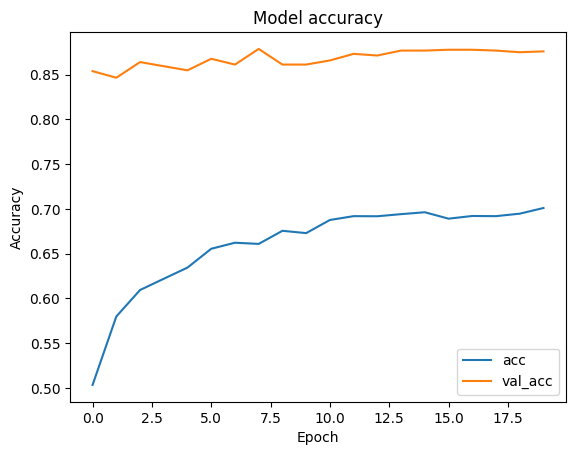

In [32]:
# plot grafik akurasi
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["acc", "val_acc"], loc="lower right")
plt.show()

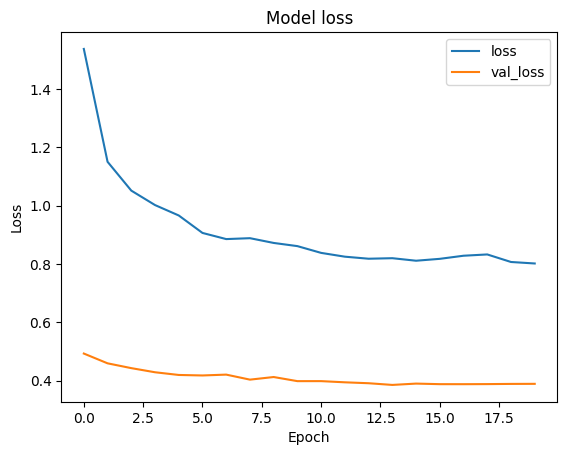

In [33]:
# plot grafik loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss", "val_loss"], loc="upper right")
plt.show()

In [34]:
# model.save("efficient.hdf5")
model.save("effifix.hdf5")

In [35]:
train_score = model.evaluate(train_batches, verbose=1)
test_score = model.evaluate(test_batches, verbose=1)

print("Train loss: ", train_score[0])
print("Train acc: ", train_score[1])
print("-" * 75)
print("Test loss: ", test_score[0])
print("Test acc: ", test_score[1])

35/35 [==============================] - 37s 1s/step - loss: 0.3987 - acc: 0.8722
Train loss:  0.5621700286865234
Train acc:  0.8028140068054199
---------------------------------------------------------------------------
Test loss:  0.39870038628578186
Test acc:  0.8721668124198914


In [36]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


34/34 [==============================] - 36s 1s/step

Classification Report:
               precision    recall  f1-score   support

       akiec    0.58824   0.33333   0.42553        30
         bcc    0.54545   0.68571   0.60759        35
         bkl    0.61017   0.40909   0.48980        88
          df    1.00000   0.12500   0.22222         8
         mel    0.54545   0.39130   0.45570        46
          nv    0.92030   0.98075   0.94956       883
        vasc    0.87500   0.53846   0.66667        13

    accuracy                        0.87217      1103
   macro avg    0.72637   0.49481   0.54530      1103
weighted avg    0.85904   0.87217   0.85857      1103



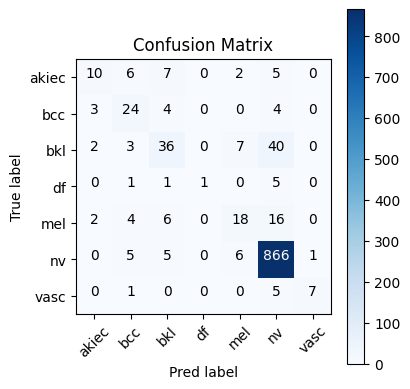

In [37]:
true_labels = test_batches.classes
model.load_weights("effifix.hdf5")

predictions = model.predict(test_batches, steps=len(test_df) / batch_size, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(4, 4))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

# # We need these to plot the confusion matrix.
# test_labels

In [38]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

# # Print the label associated with each class
# test_batches.class_indices

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


Found 39090 images belonging to 7 classes.
1222/1222 [==============================] - 1373s 1s/step

Training Classification Report:
               precision    recall  f1-score   support

       akiec    0.71966   0.83656   0.77372      5990
         bcc    0.78050   0.82304   0.80121      5798
         bkl    0.72835   0.55594   0.63057      5855
          df    0.85769   0.92286   0.88909      4330
         mel    0.73721   0.61682   0.67166      5885
          nv    0.83933   0.92909   0.88194      6022
        vasc    0.96752   0.98330   0.97535      5210

    accuracy                        0.80281     39090
   macro avg    0.80432   0.80966   0.80336     39090
weighted avg    0.79939   0.80281   0.79731     39090



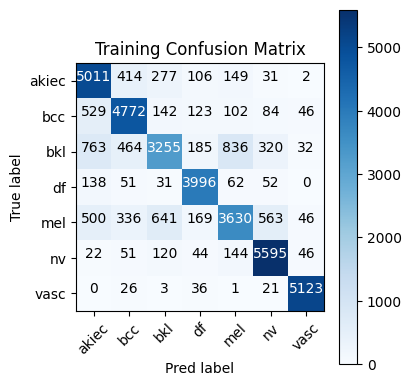

In [39]:
# Create a generator for the entire training set
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

# Calculate the number of steps needed to cover the entire training set
num_train_steps = len(train_all_batches)

# Predict labels for the entire training set
train_predictions = model.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

# Compute and print the classification report and confusion matrix
train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)
# print("\nTraining Confusion Matrix:\n", train_conf_matrix)

# Plot
plt.figure(figsize=(4, 4))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()
# # make a prediction
# predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)

## prediction by user

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input, decode_predictions
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

def predict_image_class(image_path):
    # Load the pre-trained EfficientNetB0 model
    model = load_model('effifix.hdf5')

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make prediction
    predictions =np.argmax(model.predict(img_array), axis=1)
    
    print(f"the image belongs to {[predictions[0]]}")

# Example usage
image_path = r"testing image\bcc\3.jpg"
predict_image_class(image_path)

# """""Label 2 corresponds to lesion type: Benign keratosis-- bkl
# Label 5 corresponds to lesion type: Melanocytic nevi--nv====
# Label 3 corresponds to lesion type: Dermatofibroma --df   
# Label 4 corresponds to lesion type: Melanoma --mel=====
# Label 6 corresponds to lesion type: Vascular lesions --vasc====
# Label 1 corresponds to lesion type: Basal cell carcinoma --bcc
# Label 0 corresponds to lesion type: Actinic keratoses--akiec


1/1 [==============================] - 1s 1s/step
the image belongs to [1]


In [12]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions

def get_last_conv_layer(model):
    for layer in reversed(model.layers[0].layers):  # Access internal layers of the EfficientNetB0
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No convolutional layer found in the model.")

def get_grad_cam(model, img_array, class_index):
    last_conv_layer_name = get_last_conv_layer(model)
    last_conv_layer = model.get_layer("efficientnetb0").get_layer(last_conv_layer_name)
    
    with tf.GradientTape() as tape:
        tape.watch(last_conv_layer.output)  # Ensure gradients are computed for this layer
        preds = model(img_array)
        class_output = preds[:, class_index]
    
    grads = tape.gradient(class_output, last_conv_layer.output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(last_conv_layer.output * pooled_grads[..., tf.newaxis], axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)  # Normalize
    
    return heatmap.numpy()



def overlay_heatmap(img_path, heatmap):
    # Load the original image
    img = cv2.imread(img_path)
    
    # Resize the heatmap to match the original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Overlay heatmap on the original image
    superimposed_img = heatmap * 0.4 + img
    
    return superimposed_img

def predict_image_class_with_grad_cam(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    print("Predicted class:", predicted_class_index)
    
    # Generate Grad-CAM heatmap for the predicted class
    heatmap = get_grad_cam(model, img_array, predicted_class_index)
    
    # Overlay heatmap on the original image
    superimposed_img = overlay_heatmap(image_path, heatmap)
    
    # Display the superimposed image
    cv2.imshow('Superimposed Image', superimposed_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example usage
image_path = r"testing image\bcc\3.jpg"
model = load_model('effifix.hdf5')
predict_image_class_with_grad_cam(image_path, model)


1/1 [==============================] - 1s 1s/step
Predicted class: 1


ValueError: Passed in object KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 1280), dtype=tf.float32, name=None), name='top_conv/Conv2D:0', description="created by layer 'top_conv'") of type 'KerasTensor', not tf.Tensor or tf.Variable or ExtensionType.

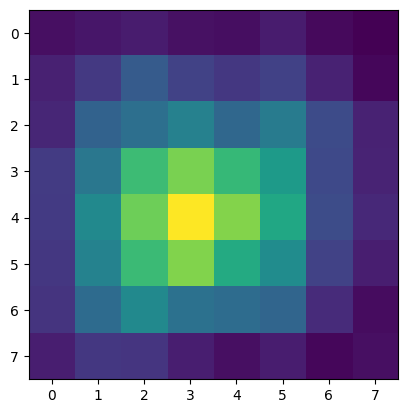

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model

# Load the pre-trained InceptionV3 model
model = InceptionV3(weights='imagenet')

# Define the target layer (choose the last convolutional layer)
last_conv_layer = model.get_layer('mixed10')

# Create a new model that outputs both the original output and the output of the last conv layer
grad_model = Model(inputs=model.inputs, outputs=[model.output, last_conv_layer.output])

def grad_cam(input_image):
    with tf.GradientTape() as tape:
        # Get the predictions and the activations from the last conv layer
        predictions, last_conv_outputs = grad_model(input_image, training=False)
        # Get the top predicted class index
        top_pred_index = tf.argmax(predictions[0])
        # Get the output of the top predicted class
        top_output = predictions[:, top_pred_index]
        # Compute the gradients of the top output with respect to the last conv layer
        grads = tape.gradient(top_output, last_conv_outputs)
        # Pool the gradients over all the axes leaving out the channel dimension
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiply each activation map by its corresponding gradient importance
    last_conv_output = last_conv_outputs[0]
    heatmap = last_conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)  # ReLU
    
    # Normalize the heatmap
    heatmap /= tf.math.reduce_max(heatmap)

    return heatmap.numpy()

# Load and preprocess an example image
img_path = r"testing image\bcc\3.jpg"
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Generate Grad-CAM heatmap
heatmap = grad_cam(x)

# Visualize the heatmap
plt.imshow(heatmap)
plt.show()


In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.models import Model

# Create an instance of the EfficientNetB0 model
model = EfficientNetB0(weights='imagenet', include_top=False)

# Define the target layer (choose the last convolutional layer before global average pooling)
last_conv_layer = model.get_layer('top_conv')

# Create a new model that outputs both the original output and the output of the last conv layer
grad_model = Model(inputs=model.inputs, outputs=[model.output, last_conv_layer.output])

def grad_cam(input_image):
    with tf.GradientTape() as tape:
        # Get the predictions and the activations from the last conv layer
        predictions, last_conv_outputs = grad_model(input_image, training=False)
        # Get the top predicted class index
        top_pred_index = tf.argmax(predictions[0])
        # Get the output of the top predicted class
        top_output = predictions[:, top_pred_index]
        # Compute the gradients of the top output with respect to the last conv layer
        grads = tape.gradient(top_output, last_conv_outputs)
        # Pool the gradients over all the axes leaving out the channel dimension
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Reshape pooled_grads to match the spatial dimensions of last_conv_output
    last_conv_output = last_conv_outputs[0]
    pooled_grads = tf.reshape(pooled_grads, (1, 1, pooled_grads.shape[0]))
    # Multiply each activation map by its corresponding gradient importance
    heatmap = last_conv_output * pooled_grads
    heatmap = tf.reduce_sum(heatmap, axis=-1)

    # Apply ReLU to the heatmap
    heatmap = tf.maximum(heatmap, 0)

    # Normalize the heatmap
    heatmap /= tf.reduce_max(heatmap)

    return heatmap.numpy()

# Load and preprocess an example image
img_path = r"testing image\bcc\3.jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Generate Grad-CAM heatmap
heatmap = grad_cam(x)

# Visualize the heatmap
plt.imshow(heatmap)
plt.show()


InvalidArgumentError: {{function_node __wrapped__Pack_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Shapes of all inputs must match: values[0].shape = [] != values[1].shape = [7,1280] [Op:Pack] name: 